In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import rasterio
from rasterio import features
import shapely
from shapely.geometry import Point, Polygon

df = pd.read_csv("hubmap-organ-segmentation/train.csv")
df['image_path'] = 'hubmap-organ-segmentation/train_images/'
df['image_path'] = df['image_path'].str.cat(df['id'].astype(str))
df['image_path'] = df['image_path'] + '.tiff'
df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex                                         image_path  
0    Male  hubmap-organ-segmentation/train_images/10044.tiff  
1    Male  hubmap-organ-segmentation/train_images/10274.tiff  
2    Male  hubmap-organ-segmentation/train_images/10392.tiff  
3    Male  hubmap-organ-segmentation/train_images/10488.tiff  
4  Female  hubmap-organ-segmentation/train_images/10610.tiff

In [2]:
def helper(mask, img_shape):
  
    canvas = np.zeros(img_shape).T
    canvas[tuple(zip(*mask))] = 1.0

      # This is the Equivalent for loop of the above command for better understanding.
      # for pos in range(len(p_loc)):
      #   canvas[pos[0], pos[1]] = 1

    return canvas

def get_mask(rle_string, img_shape):
    rle = [int(i) for i in rle_string.split(' ')]
    pairs = list(zip(rle[0::2],rle[1::2]))

    p_loc = []

    for start, length in pairs:
        for p_pos in range(start, start + length):
            p_loc.append((p_pos % img_shape[1], p_pos // img_shape[0]))
  
    return helper(p_loc, img_shape)


def mask_to_polygons_layer(mask:np.array) -> shapely.geometry.Polygon:
    """Converting mask to polygon object
    
    Input:
        mask: (np.array): Image like Mask [0,1] where all 1 are consider as masks
        
    Output:
        shapely.geometry.Polygon: Polygons
    
    """
    all_polygons = []
    for shape, value in features.shapes(mask.astype(np.int16), mask=(mask >0), transform=rasterio.Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shapely.geometry.shape(shape))

    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons

def get_date(id:int) -> tuple:
    """Get Important data
    
    Input:
        id: (int) id of the data
        get_vals: (list) List of the cols you want to get from the data
    
    Output:
        tuple:
            int: Image id
            tuple: Image shape (height, width)
            image_path: Path of the image
            image: PIL Image object 
            polygons: Polygon points list
            mask: Mask of the image
        
    """
    get_vals = ["id",'img_height', 'img_width','image_path', 'rle']
    values = list()
    for i in get_vals:
        values.append(list(df[df["id"]==id][i].values)[0])

    # Getting image data
    img_id, img_height, img_width, image_path, rle = values
    img_shape = (img_width, img_height)
    image = Image.open(image_path)
    
    mask = get_mask(rle, img_shape)
    
    # Converting Mask to Polygon
    polygons = mask_to_polygons_layer(mask)
    polygons = [list(poly.exterior.coords) for poly in list(polygons)]
    return (img_id, img_shape, image_path, image, polygons, mask)



# Draw Polygon

/tmp/ipykernel_16732/3793752562.py:80: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  polygons = [list(poly.exterior.coords) for poly in list(polygons)]
/tmp/ipykernel_16732/3793752562.py:80: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygons = [list(poly.exterior.coords) for poly in list(polygons)]


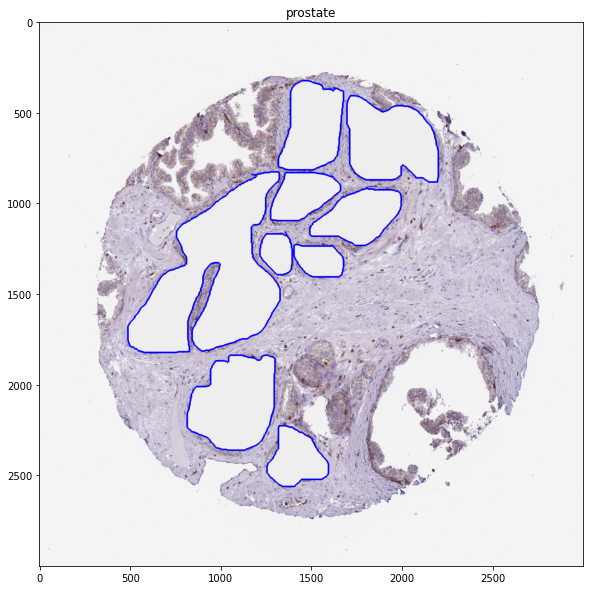

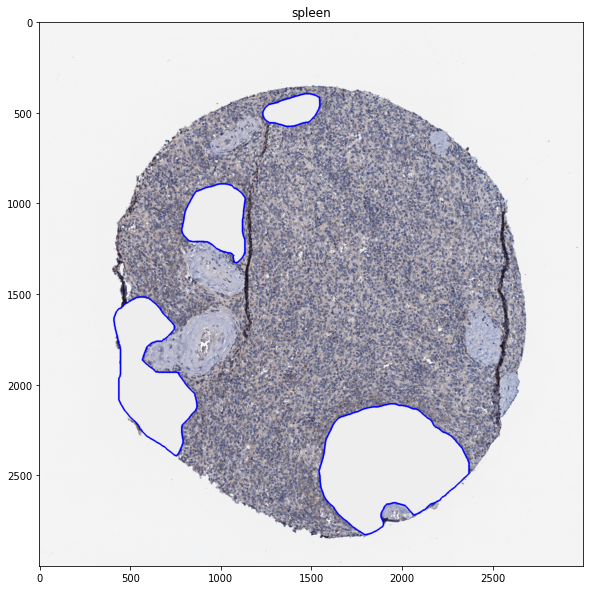

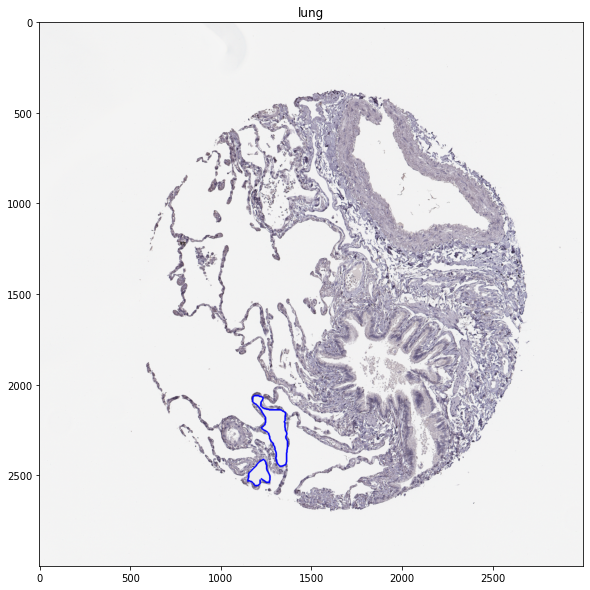

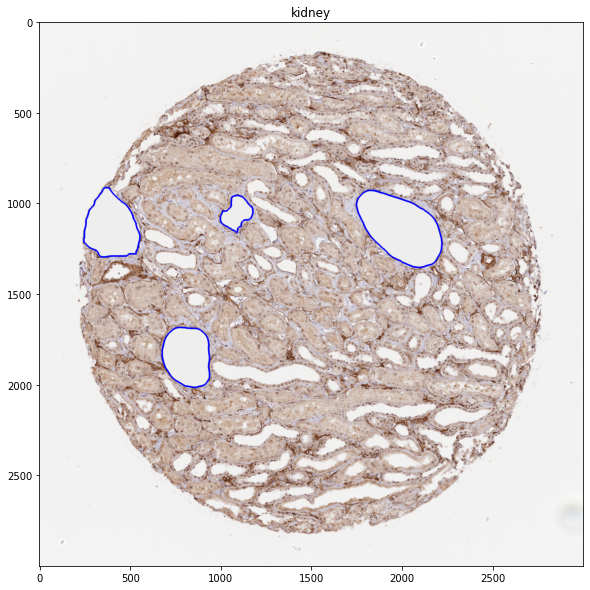

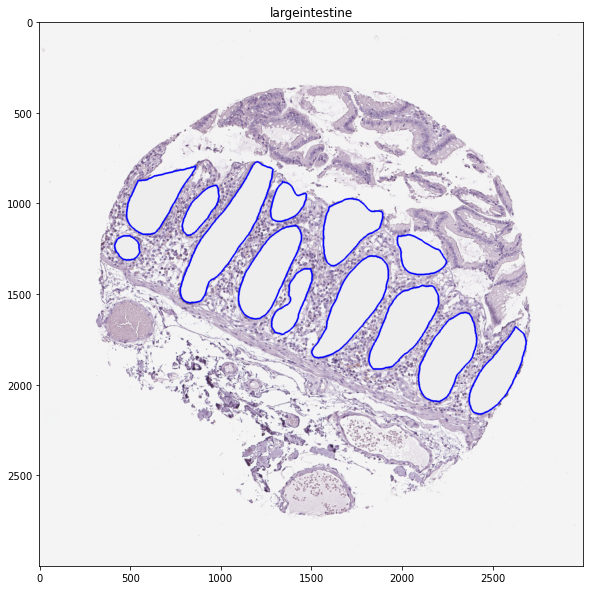

In [3]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath 
  
for part in df['organ'].unique():
    
    idx = list(df[df['organ']==part]["id"].values)[0]
    
    img_id, img_shape, image_path, image, polygons, mask = get_date(idx)
    img1 = ImageDraw.Draw(image) 

    for points in polygons:
        img1.polygon(points,fill="#eeeeee", outline ="blue", width=9) 
    
    
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.title(part)
    plt.show()

# Draw Masks

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


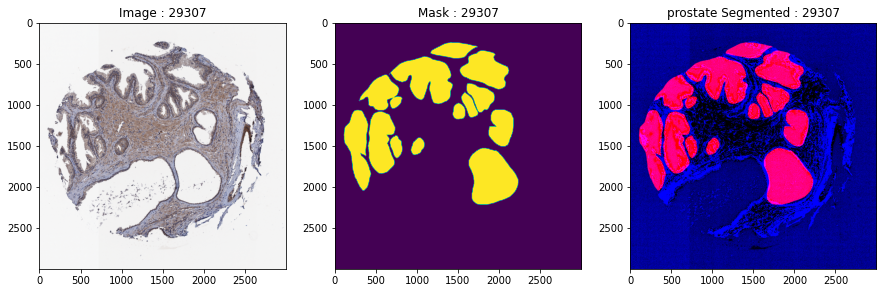

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


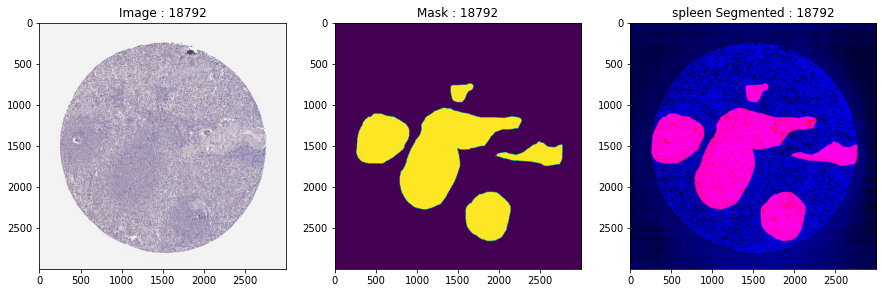

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


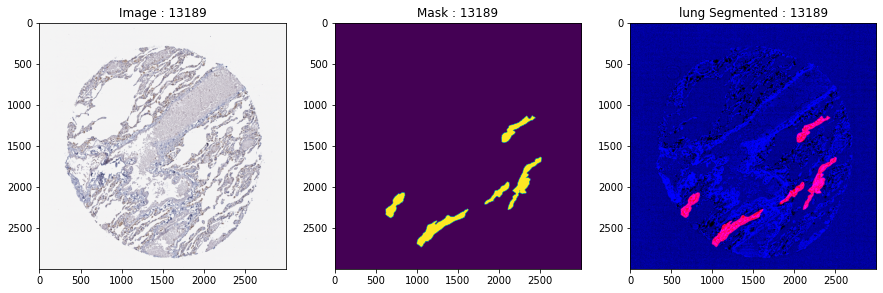

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


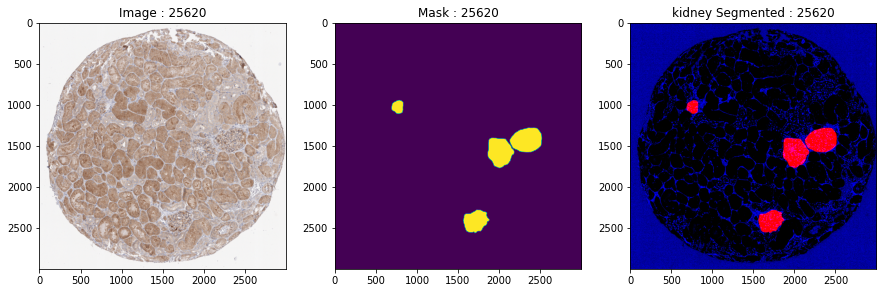

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


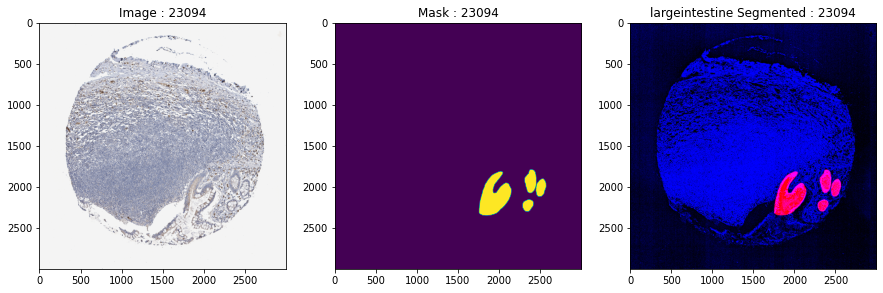

In [4]:
for part in df['organ'].unique():

  x = df[df['organ'] == part]
  index_list = x.index
  idx = index_list[np.random.randint(0, x.shape[0])]

  class_of_scan = df.loc[idx, 'organ']
  image_path = df.loc[idx, 'image_path']
  id = df.loc[idx, 'id'] 
  
  image = np.array(Image.open(image_path)) / 255
  k = (df.loc[idx, 'img_height'], df.loc[idx, 'img_width'])

  rle_string = df.loc[idx, 'rle']
  mask = get_mask(rle_string, k)


  fig, ax = plt.subplots(1,3, figsize=(15,15))
  ax[0].set_title(f'Image : {id}')
  ax[0].imshow(image)

  ax[1].set_title(f'Mask : {id}')
  ax[1].imshow(mask)

  ax[2].set_title(f'{class_of_scan} Segmented : {id}')
  ax[2].imshow(np.dstack((mask, np.zeros(mask.shape), np.argmax(image, axis=-1))))
  plt.show()

In [5]:
img_id, img_shape, image_path, image, polygons, mask = get_date(11645)

/tmp/ipykernel_16732/3793752562.py:80: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  polygons = [list(poly.exterior.coords) for poly in list(polygons)]
/tmp/ipykernel_16732/3793752562.py:80: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygons = [list(poly.exterior.coords) for poly in list(polygons)]


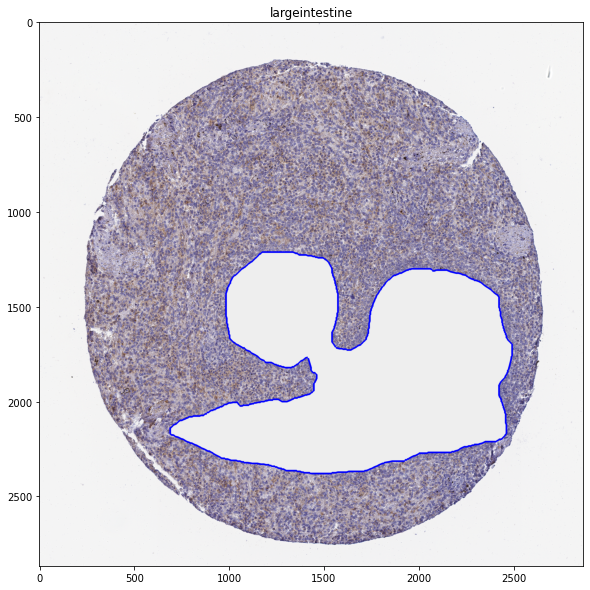

In [6]:
img1 = ImageDraw.Draw(image) 

for points in polygons:
    img1.polygon(points,fill="#eeeeee", outline ="blue", width=9) 


plt.figure(figsize=(20,10))
plt.imshow(image)
plt.title(part)
plt.show()

# Making Tiles

In [150]:
import numpy as np
from PIL import Image

def tile_image(p_img, folder, h: int = 512, w: int = 512) -> list:
    im = np.array(Image.open(p_img))
    # https://stackoverflow.com/a/47581978/4521646
    tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    idxs = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
    name, _ = os.path.splitext(os.path.basename(p_img))
    files = []
    for k, tile in enumerate(tiles):
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile = np.zeros_like(tiles[0])
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
        p_img = os.path.join(folder, f"{name}_{k:02}.png")
        Image.fromarray(tile).save(p_img)
        files.append(p_img)
    return files, idxs

tile_size = 256
image_size = (3000, 3000)
tiles_img, _ = tile_image("hubmap-organ-segmentation/train_images/12233.tiff", "hubmap-organ-segmentation/tiles/images", h=tile_size, w=tile_size)
tiles_seg, idxs = tile_image("hubmap-organ-segmentation/train_masks/12233.tiff", "hubmap-organ-segmentation/tiles/masks", h=tile_size, w=tile_size)



size = math.ceil(image_size[0]/tile_size)

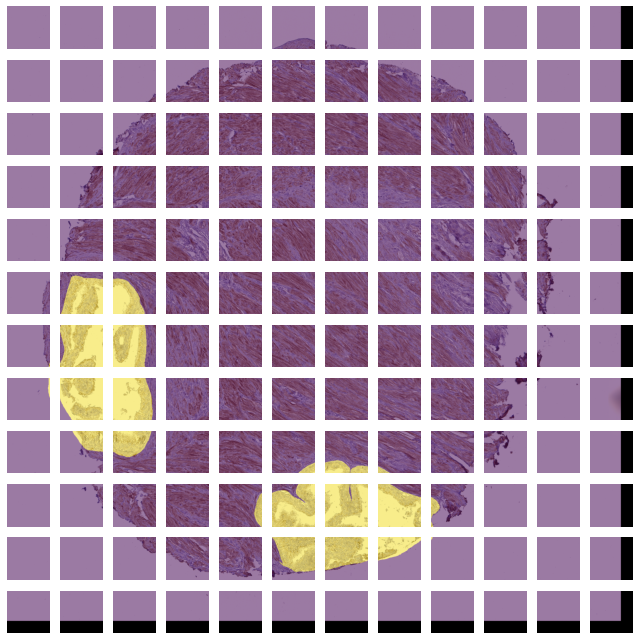

In [151]:


import matplotlib.pyplot as plt
from skimage import color

fig, axes = plt.subplots(nrows=size, ncols=size, figsize=(9, 9))

for i, (p_img, p_seg) in enumerate(zip(tiles_img, tiles_seg)):
    img = Image.open(p_img).convert("RGB")
    mask = Image.open(p_seg).convert("RGB")
    
    axes[i // size, i % size].imshow(Image.blend(mask, img, 0.5))
    axes[i // size, i % size].set_axis_off()
    
fig.tight_layout()


In [159]:
# import glob, tqdm

# # Making tiles of all images
images  = "hubmap-organ-segmentation/val_images/*"
masks = "hubmap-organ-segmentation/val_masks/*"
for i in tqdm.tqdm(glob.glob(images)):
    tiles_img, _ = tile_image(i, "hubmap-organ-segmentation/tiles/val_images", h=tile_size, w=tile_size)
    


for i in tqdm.tqdm(glob.glob(masks)):
    tiles_img, _ = tile_image(i, "hubmap-organ-segmentation/tiles/val_masks", h=tile_size, w=tile_size)
    


100%|██████████| 50/50 [00:34<00:00,  1.45it/s]
